# Vacuum in the squeezed hierarchy

In [33]:
from functools import partial

import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier

In [9]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [3]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def make_squeezed_state_vec(r, mu, N, normalized=True):
    r'''Make a truncated squeezed-state vector.

    The squeezed-state vector is :math:`S(r,\mu)|0\rangle`. The truncated
    vector is renormalized by default.

    Parameters
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}
    r: real number
        Squeezing amplitude
    mu: real number
        Squeezing phase
    normalized: boolean
        Whether or not the truncated vector is renormalized

    Returns
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the
        number basis

    '''
    ket = np.zeros(N, dtype=np.complex)
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket) if normalized else ket

def sqz_rho(r, mu, n):
    return rho_from_ket(make_squeezed_state_vec(r, mu, n + 1))

In [4]:
r = np.log(2)
mu = 0

In [5]:
n_maxs = np.arange(1, 13)
factories = {n_max: hier.HierarchyIntegratorFactory(2, n_max)
             for n_max in n_maxs}

In [7]:
xi_fn = partial(xi_rect, a=0, b=1)

In [8]:
factory = factories[1]

In [10]:
integrators = {n_max: factory.make_uncond_integrator(xi_fn, Id, sm, zero, r, mu)
              for n_max, factory in factories.items()}

In [11]:
times = np.linspace(0, 1, 2**8 + 1)

In [20]:
rho0 = (Id + sz)/2

In [21]:
field_rho0s = {n_max: sqz_rho(-r, mu, n_max) for n_max in n_maxs}

In [22]:
solns = {n_max: integrator.integrate(rho0, times) for n_max, integrator in integrators.items()}

In [30]:
Pe_expts = {n_max: solns[n_max].get_expectations((Id + sz)/2, field_rho0s[n_max]) for n_max in n_maxs}

In [34]:
vac_integrator = integ.UncondLindbladIntegrator([sm], zero)
vac_soln = vac_integrator.integrate(rho0, times)
vac_Pe_expt = vac_soln.get_expectations((Id + sz)/2)

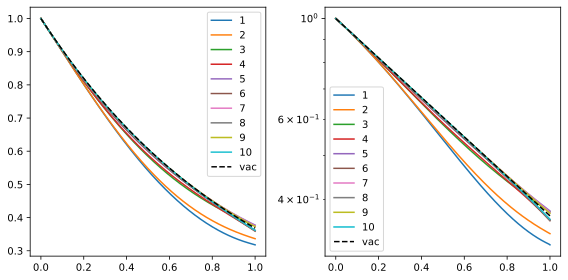

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
for n_max in n_maxs[:10]:
    axs[0].plot(times, Pe_expts[n_max], label=str(n_max))
    axs[1].semilogy(times, Pe_expts[n_max], label=str(n_max))
axs[0].plot(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[1].semilogy(times, vac_Pe_expt, color='k', linestyle='--', label='vac')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

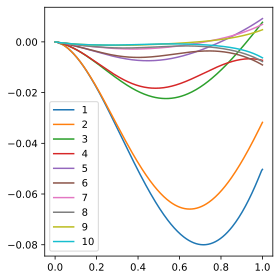

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
for n_max in n_maxs[:10]:
    ax.plot(times, Pe_expts[n_max] - vac_Pe_expt, label=str(n_max))
ax.legend()
plt.tight_layout()
plt.show()

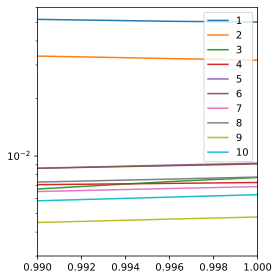

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
for n_max in n_maxs[:10]:
    ax.semilogy(times, np.abs(Pe_expts[n_max] - vac_Pe_expt), label=str(n_max))
ax.set_ylim(3e-3, 6e-2)
ax.set_xlim(.99, 1)
ax.legend()
plt.tight_layout()
plt.show()